In [1]:
# Solving and simulating a RBC model adapted from Fabrice Collard's Matlab code, http://fabcol.free.fr/
# tested in Julia 1.11
# this code is part of chapter 3, "Solving and Simulating DSGE Models" from the book: "Introduction to Quantitative Macroeconomics using Julia"
# Academic Press - Elsevier
# for comments, email at: petre(dot)caraiani(at)gmail(dot)com
alpha = 0.4;
delta = 0.025;
rho  = 0.95;
beta= 0.988;
hs   = 0.31;
sz   = 0.00217;

# Deterministic Steady state

ysk = (1-beta*(1-delta))/(alpha*beta);
ksy = 1/ysk;
si  = delta/ysk;
sc  = 1-si;

#Define:
#Y=[k(t+1) a(t+1) E_tc(t+1)]
#X=[y,c,i,h]

ny  = 3;  # of variables in vector Y
nx  = 4;  # of variables in vector X
ne  = 1;  # of fundamental shocks
nn  = 1;  # of expectation errors

# Initialize the Upsilon matrices

UX=zeros(nx,nx);
UY=zeros(nx,ny);
UE=zeros(nx,ne);
UN=zeros(nx,nn);

G0Y=zeros(ny,ny);
G1Y=zeros(ny,ny);
G0X=zeros(ny,nx);
G1X=zeros(ny,nx);
GE=zeros(ny,ne);
GN=zeros(ny,nn);

# Production function

UX[1,1]=1;
UX[1,4]=alpha-1;
UY[1,1]=alpha;
UY[1,2]=rho;
UE[1]=1;

#Consumption c(t)=E(c(t)|t-1)+eta(t)
UX[2,2]=1;
UY[2,3]=1;
UN[2]=1;

# Resource constraint

UX[3,1]=1;
UX[3,2]=-sc;
UX[3,3]=-si;

# Consumption-leisure arbitrage

UX[4,1]=-1;
UX[4,2]=1;
UX[4,4]=1;

# Accumulation of capital

G0Y[1,1]=1;
G1Y[1,1]=1-delta;
G1X[1,3]=delta;

# Productivity shock

G0Y[2,2]=1;
G1Y[2,2]=rho;
GE[2]=1;

# Euler equation

G0Y[3,1]=1-beta*(1-delta);
G0Y[3,3]=1;
G0X[3,1]=-(1-beta*(1-delta));
G1X[3,2]=1;

# Solution

# Step 1: solve the first set of equations

PIY = inv(UX)*UY;
PIE = inv(UX)*UE;
PIN = inv(UX)*UN;

# Step 2: build the standard System

A0  = G0Y+G0X*PIY;
A1  = G1Y+G1X*PIY;
B   = GE+G1X*PIE;
C   = GN+G1X*PIN;




In [3]:
#First we compute the Schur decomposition A0=Q'*T*Z' and A1=Q'*S*Z'
using LinearAlgebra

# Generalized Schur (QZ) of (A1, A0)
r = schur(ComplexF64.(A1), ComplexF64.(A0))   # r is a GeneralizedSchur

# Generalized eigenvalues λ = diag(S) ./ diag(T)
λ = diag(r.S) ./ diag(r.T)

# Select which eigenvalues you want “first” (e.g. |λ| < cutoff)
cutoff = 1.0
sel = abs.(λ) .< cutoff

# Reorder Schur form so selected eigenvalues come first
ordschur!(r, sel)   # in-place reordering

# Extract factors (note: ' is conjugate-transpose)
S = r.S
T = r.T
Q = r.Q'            # so that Q*A1*Z = S  and  Q*A0*Z = T
Z = r.Z


n           = size(A0,1);   # number of variables
nf          = size(B,2);    # number of fundamental shocks
ne          = size(C,2);    # number of expectation errors



In [4]:
# Calculate the number of unstable eigenvalues
m = n-sum(sel);

Q1          = Q[1:n-m,:];
Q2          = Q[n-m+1:n,:];
Z1          = Z[:,1:n-m]';
Z2          = Z[:,n-m+1:n]';

#r_svd       = svdfact(Q2*C);
# old: r_svd[:U], r_svd[:S], r_svd[:V]
# new: F.U      , F.S      , F.Vt'  (V = Vt')
F = svd(Q1*C)          # SVD object
U1, D1, V1 = F.U, F.S, F.V
r1       = rank(Q1*C);               # number of linearly independent forecast errors


T11         = T[1:n-m,1:n-m];
T12         = T[1:n-m,n-m+1:n];
T22         = T[n-m+1:n,n-m+1:n];

T1i         = inv(T11);
S11         = S[1:n-m,1:n-m];
S12         = T[1:n-m,n-m+1:n];
S22         = T[n-m+1:n,n-m+1:n];


F = svd(Q2*C)          # SVD object
U2, D2, V2 = F.U, F.S, F.V
r2       = rank(Q2*C);               # number of linearly independent forecast errors

In [5]:
k = n - m 
I_k  = Matrix(I, k, k)
I_m = Matrix(I, m, m)

Phi         = ((U2[:,1:r2]*(D2[1:r2,1:r2]\V2[:,1:r2]'))*(V1[:,1:r1]*D1[1:r1,1:r1]*U1[:,1:r1]'))';


Transfo     = [I_k -Phi];
MY0         = inv([Transfo*T;zeros(m,n-m) I_m]);
MY1         = ([Transfo*S;zeros(m,n)]);
MY          = Z*(MY0*MY1)*Z';

if ne>r2;    
    println("Indeterminacy: adding beliefs")
    ME          = MY0*[Transfo*Q*[B C];zeros(m,size([B C],2))];
    ME          = Z*ME;
    ETA         = (U2[:,1:r2]*(D2[1:r2,1:r2]\V2[:,1:r2]'))'*Q2*[B C];
else
    ME          = MY0*[Transfo*Q*B;zeros(m,size(B,2))];
    ME          = Z*ME;
    ETA         = (U2[:,1:r2]*(D2[1:r2,1:r2]\V2[:,1:r2]'))'*Q2*B;
end

1×1 Matrix{ComplexF64}:
 -0.44045531456330106 + 0.0im

In [6]:
k = n - m                      # size you want

Iop = I                        # identity *operator* (no allocation), works in muls
A  = Matrix(I, k, k)           # dense k×k identity (Bool eltype)


2×2 Matrix{Bool}:
 1  0
 0  1

In [7]:
#solutions
MY  = real(MY);
ME  = real(ME);
ETA = real(ETA);


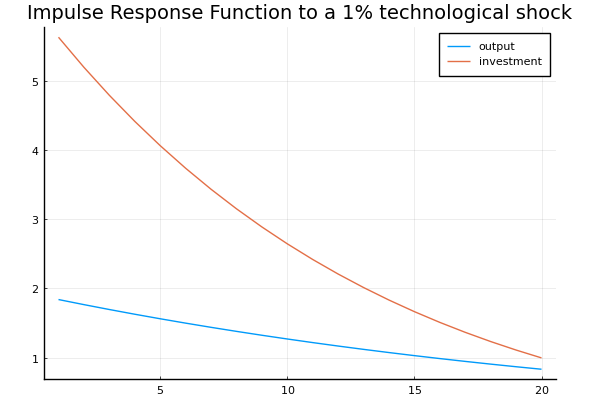

In [8]:
#simulate
# Step 4: Recover the impact function

PIE=PIE-PIN*ETA;

#horizon of responses
nrep    = 20;           
YS      = zeros(3,nrep);
XS      = zeros(4,nrep);
Shock   = 1;
YS[:,1] = ME*Shock;
XS[:,1] = PIE;
for t=2:nrep;
    YS[:,t] = MY*YS[:,t-1];
    XS[:,t] = PIY*YS[:,t-1];
end

#Pkg.add("Plots")
using Plots
pyplot()
#plotly() # Choose the Plotly.jl backend for web interactivity
plot(XS[1,:],linewidth=1,label="output",title="Impulse Response Function to a 1% technological shock")
plot!(XS[3,:],linewidth=1,label="investment")

